In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp
from scipy.integrate import cumulative_simpson as cumsimp
from scipy.linalg import cholesky, solve_triangular, solve

import dickandballs as db
import helpers as hel

# chiral eft

In [2]:
def downsample_array(array, target_size):
    """
    Downsample an array to the target size and return the downsampled array and the corresponding indices.
    
    Parameters:
    - array: The input array to downsample.
    - target_size: The target size for the downsampled array.

    Returns:
    - downsampled_array: The downsampled array.
    - indices: The indices used for downsampling.
    """
    total_size = len(array)
    indices = np.linspace(0, total_size - 1, target_size, dtype=int)
    downsampled_array = array[indices]
    return downsampled_array, indices

In [3]:
ceft_lower= np.loadtxt('EOS/ceft/eos_ceft_lower.dat')
n_ceft_lower, p_ceft_lower, e_ceft_lower = ceft_lower.T

ceft_upper= np.loadtxt('EOS/ceft/eos_ceft_upper.dat')
n_ceft_upper, p_ceft_upper, e_ceft_upper = ceft_upper.T

n_ceft = n_ceft_lower/0.16 #n_sat


In [4]:
p_ceft_upper, downed_indices = downsample_array(p_ceft_upper, 50)
p_ceft_lower = p_ceft_lower[downed_indices]
e_ceft_upper = e_ceft_upper[downed_indices]
e_ceft_lower = e_ceft_lower[downed_indices]
n_ceft = n_ceft[downed_indices]


In [5]:
cs2_ceft_lower = np.gradient(p_ceft_lower, e_ceft_lower) #dp/de
cs2_ceft_upper = np.gradient(p_ceft_upper, e_ceft_upper) #dp/de
cs2_ceft_avg = (cs2_ceft_upper+cs2_ceft_lower)/2
cs2_ceft_width = cs2_ceft_upper-cs2_ceft_lower
cs2_ceft_sigma = hel.CI_to_sigma(cs2_ceft_width)

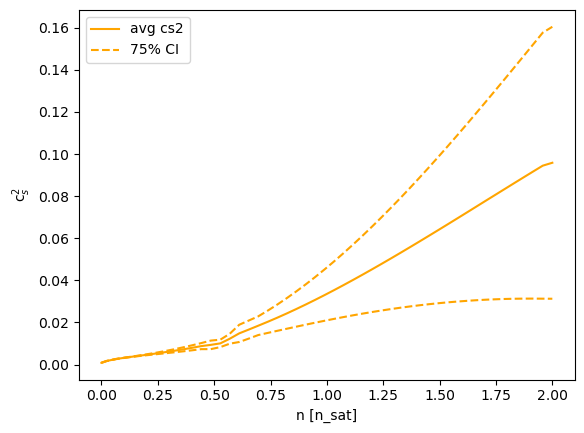

In [6]:
plt.plot(n_ceft, cs2_ceft_avg, color='orange', label='avg cs2')

plt.plot(n_ceft, cs2_ceft_avg+cs2_ceft_width/2, '--', color='orange', label='75% CI')
plt.plot(n_ceft, cs2_ceft_avg-cs2_ceft_width/2, '--', color='orange')


plt.ylabel(r'c$_s^2$')
plt.xlabel('n [n_sat]')
plt.legend()
plt.show()



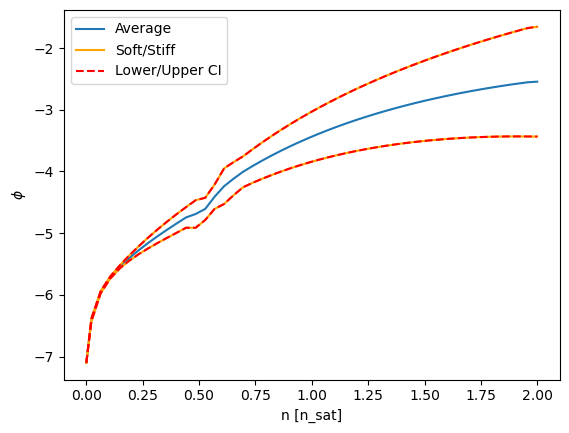

In [7]:
phi_ceft_lower = hel.get_phi(cs2_ceft_lower)
phi_ceft_upper = hel.get_phi(cs2_ceft_upper)
phi_ceft_width = phi_ceft_upper-phi_ceft_lower
phi_ceft_avg = (phi_ceft_upper+phi_ceft_lower)/2
phi_ceft_sigma = hel.CI_to_sigma(phi_ceft_width)

plt.plot(n_ceft, phi_ceft_avg, label='Average')
plt.plot(n_ceft, phi_ceft_lower, color='orange')
plt.plot(n_ceft, phi_ceft_upper, color='orange', label='Soft/Stiff')
plt.plot(n_ceft, phi_ceft_avg+phi_ceft_width/2, '--', color='red', label='Lower/Upper CI')
plt.plot(n_ceft, phi_ceft_avg-phi_ceft_width/2, '--', color='red')
plt.ylabel(r'$\phi$')
plt.xlabel('n [n_sat]')
plt.legend()
plt.show()


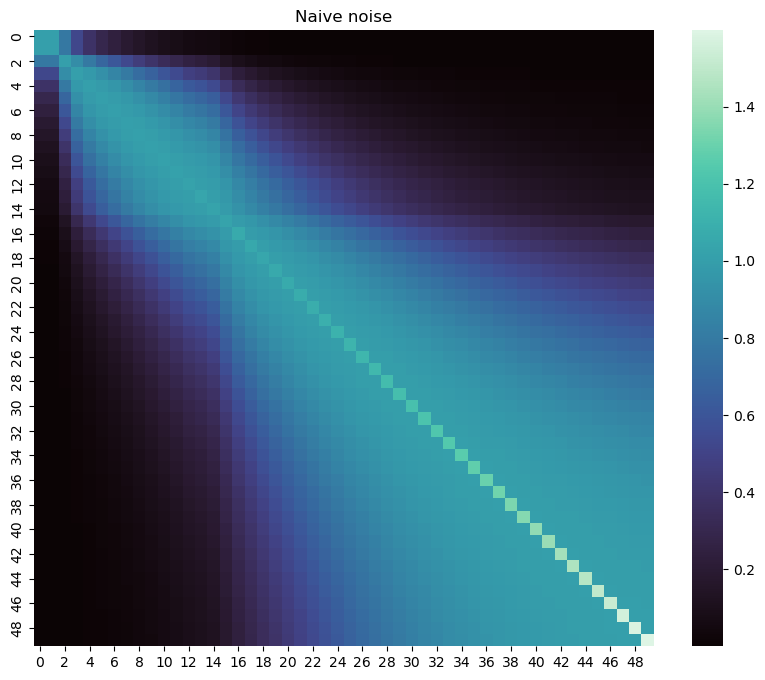

In [27]:
kern = db.Kernel('SE', sigma = 1, l = 1)
K11 = kern.compute(phi_ceft_avg)

noise_kern = K11 + np.diag(phi_ceft_sigma**2)
kern.visualise_kernel(noise_kern, 'Naive noise', annotation=False)


# GPR

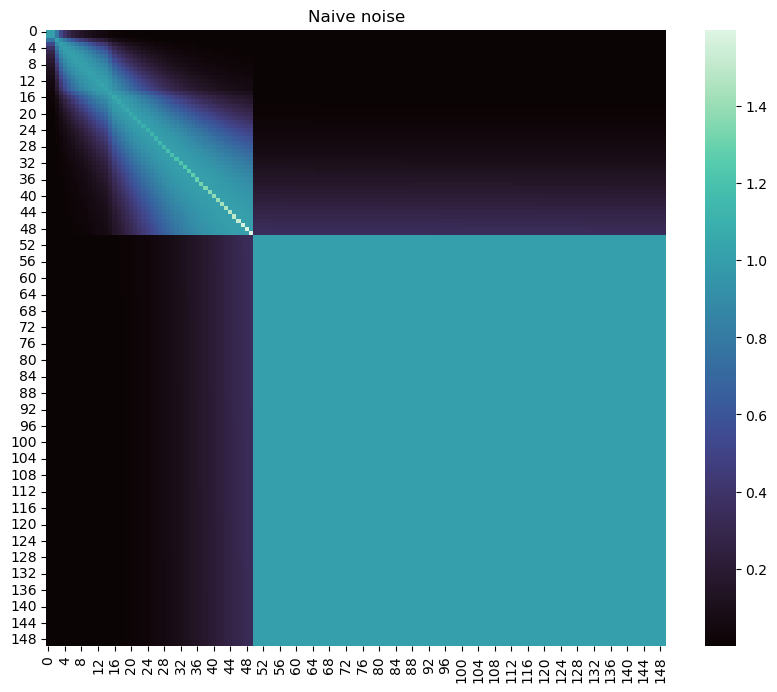

In [25]:
kern = db.Kernel('SE', sigma = 1, l = 1)
K11 = kern.compute(hel.get_phi(cs2_train))

noise_kern = K11 + np.diag(phi_sigma_train**2)
kern.visualise_kernel(noise_kern, 'Naive noise', annotation=False)


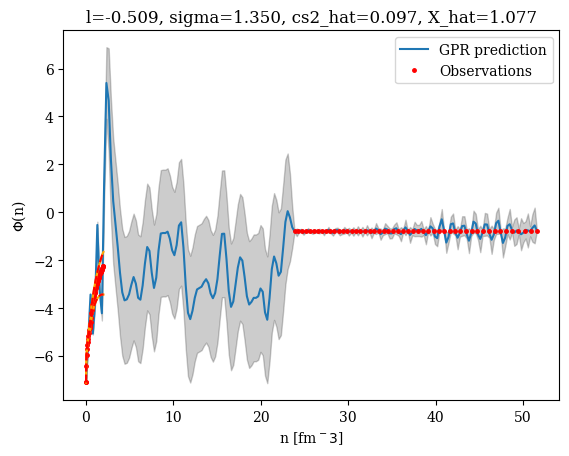

In [204]:
cs2_hat, nu_hat, l_hat, X_hat = hel.get_hype_samples()

kernel = db.Kernel('SE', sigma=nu_hat, l=l_hat)

n_pqcd, cs2_pqcd = hel.get_pqcd(X_hat, size=50)

x_train =  np.concatenate((n_ceft, n_pqcd))
cs2_train =  np.concatenate((cs2_ceft_avg, cs2_pqcd))

phi_pqcd_sigma = np.zeros_like(cs2_pqcd)
phi_sigma_train = np.concatenate((phi_ceft_sigma, phi_pqcd_sigma))
phi_train = hel.get_phi(cs2_train)
train_noise = phi_sigma_train**2

x_test = np.linspace(n_ceft[0], n_pqcd[-1], 200) # number density, starting val is ending val of n crust


gp = db.GP(kernel, hel.get_phi(cs2_hat))
gp.fit(x_train, x_test, phi_train, var_f = train_noise, stabilise=True)

phi_test, sig = gp.posterior()


plt.rcParams["font.family"] = "serif"

plt.plot(x_test, phi_test[0], label=f'GPR prediction')
plt.plot(x_train, phi_train, 'r.', markersize=5, label='Observations')
plt.fill_between(x_test.ravel(), phi_test[0] - 1.96 * sig, phi_test[0] + 1.96 * sig, alpha=0.2, color='k')
plt.xlabel('n [fm$^-3$]')
plt.ylabel(r'$\Phi$(n)')
plt.title(f"l={l_hat:.3f}, sigma={nu_hat:.3f}, cs2_hat={cs2_hat:.3f}, X_hat={X_hat:.3f}")
plt.legend()

plt.plot(n_ceft, phi_ceft_lower, color='orange')
plt.plot(n_ceft, phi_ceft_upper, color='orange', label='Soft/Stiff')
plt.plot(n_ceft, phi_ceft_avg+phi_ceft_width/2, '--', color='red', label='Lower/Upper CI')
plt.plot(n_ceft, phi_ceft_avg-phi_ceft_width/2, '--', color='red')


plt.show()

